# Anomaly Detection with Logistic Regression

In [1]:
# Download data - please only run this once
import urllib.request
import zipfile
import os

print("Starting download ...")
urls = [
    "https://github.com/aihack20/shell_challenge/releases/download/data/clean_dataset.zip",
    "https://github.com/aihack20/shell_challenge/releases/download/data/raw_dataset.zip",
]
os.makedirs("shell_data", exist_ok=True)
for url in urls:
    with urllib.request.urlopen(url) as src:
        with open("tmp.zip", "wb") as dest:
            dest.write(src.read())
    print("Unpacking archive ...")
    with zipfile.ZipFile("tmp.zip") as f:
        f.extractall("shell_data")
print("Done!")

Starting download ...
Unpacking archive ...
Unpacking archive ...
Done!


In [5]:
import pandas as pd
import numpy as np

In [3]:
# Load the data (will take a short while)
clean_data = pd.read_csv("shell_data/clean_dataset.csv")
raw_data = pd.read_csv("shell_data/raw_dataset.csv")

/scratch/vs488/home/anaconda3/envs/aihack/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,239,240,241,242,243,244,24

In [6]:
t_anomaly = np.array([10634, 36136, 57280, 57618, 60545, 63144, 118665, 128524, 131118])

## Split Data into Labeled snippets

First, we split the data into chunks having a length of 10 time steps. This corresponds to a temporal length of 90 minutes. This is time window is much longer than thermal and mechanical processes. Hence, the data within this time frame should be sufficient to explain why and how the anomaly arised.

In [21]:
# Remove rows with missing values
clean_data_ = clean_data.dropna()

# Prepare variables 
chunked_data = []
targets = []
ind_anom = 0
chunk_length = 10 # length of time frame
n_chunks = clean_data_.shape[0] // chunk_length
for i in range(n_chunks):
    chunked_data.append(pd.DataFrame.to_numpy(clean_data_.iloc[(i * chunk_length):((i + 1) * chunk_length)]))
    if i > 0:
        if ind_anom < len(t_anomaly) and chunked_data[i][0, -1] > t_anomaly[ind_anom]:
            targets.append(1)
            ind_anom += 1
        else:
            targets.append(0)
targets.append(0)

chunked_data = np.array(chunked_data)
targets = np.array(targets)

# Remove time from chunked data
chunked_data = chunked_data[:, :, :-1]

In [23]:
# Save numpy variables to file
np.save('shell_data/chunked_data.npy', chunked_data)
np.save('shell_data/targets.npy', targets)

# Run Principal Component Analysis on Chunked Data

In [24]:
# Load packages
from matplotlib import pyplot as plt
from sklearn import decomposition as dc

In [25]:
# Load data
chunked_data = np.load('shell_data/chunked_data.npy')
targets = np.load('shell_data/targets.npy')

In [27]:
# Normalize data
y = targets
ind_anomaly = np.where(y == 1)[0]
ind_no_anomaly = np.array_split(np.where(y == 0)[0], 9)
X = chunked_data.reshape(chunked_data.shape[0], np.prod(chunked_data.shape[1:]))
X_mean = np.mean(X, 1, keepdims=True)
X_std = np.std(X, 1, keepdims=True)
X_norm = (X - X_mean) / X_std

In [28]:
# Do PCA
pca = dc.PCA(n_components=3)
pca.fit(X_norm)
X_trans = pca.transform(X_norm)

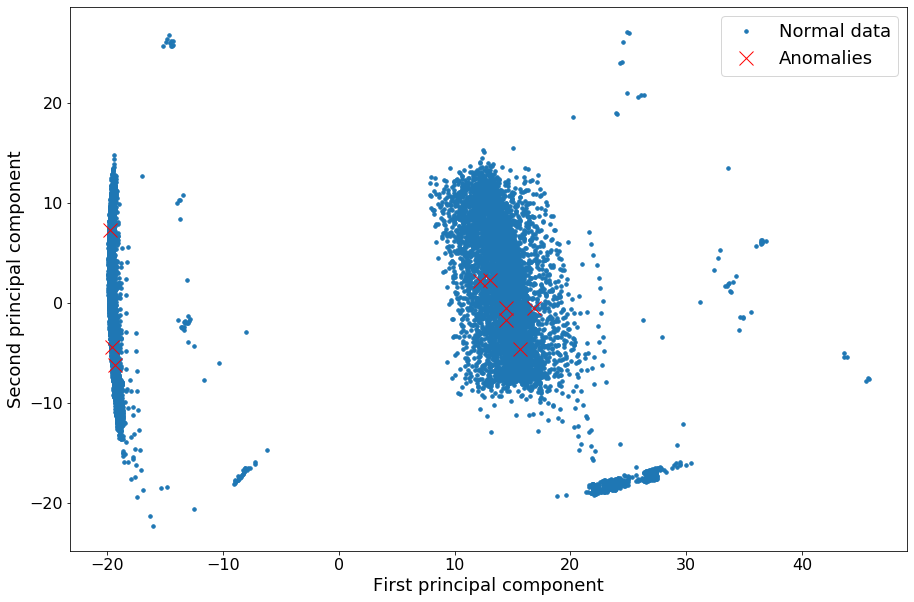

In [43]:
# Plot first two principle components
ind0 = 0
ind1 = 1
plt.figure(figsize=(15, 10))
plt.plot(X_trans[:, ind0], X_trans[:, ind1], '.', markersize=7)
plt.plot(X_trans[ind_anomaly, ind0], X_trans[ind_anomaly, ind1], 'rx', markersize=14)
plt.legend(['Normal data', 'Anomalies'], fontsize=18)
plt.xlabel('First principal component', fontsize=18)
plt.ylabel('Second principal component', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Clearly, the anomalies seem to cluster within two regions.
Now, we want to train a 

In [31]:
def get_x_tilde(X): return np.concatenate((np.ones((X.shape[0], 1 )), X), 1)

def evaluate_basis_functions(l, X, Z):
    X2 = np.sum(X ** 2, 1)
    Z2 = np.sum(Z ** 2, 1)
    ones_Z = np.ones(Z.shape[0])
    ones_X = np.ones(X.shape[0])
    r2 = np.outer(X2, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z2)
    return np.exp(-0.5 / l ** 2 * r2)

In [32]:
# Fit logistic regression model
l = 1.5
for i in range(9):
    ind_fold = np.concatenate((np.array([ind_anomaly[i]]), ind_no_anomaly[i]))
    X_fold_ref = np.delete(X_trans, ind_fold, 0)[::100, :]
    X_fold_train = get_x_tilde(evaluate_basis_functions(l, np.delete(X_trans, ind_fold, 0), X_fold_ref))
    y_fold_train = np.delete(y, ind_fold, 0)
    X_fold_test = get_x_tilde(evaluate_basis_functions(l, X_trans[ind_fold, :], X_fold_ref))
    y_fold_test = y[ind_fold]
    log_reg = lm.LogisticRegression(max_iter=10000, class_weight='balanced')
    log_reg.fit(X_fold_train, y_fold_train)
    y_fold_pred = log_reg.predict(X_fold_test)
    print(np.mean(y_fold_test == y_fold_pred))
    ind_a = np.where(y_fold_test == 1)[0]
    print(y_fold_pred[ind_a])
    y_fold_pred = log_reg.predict(X_fold_train)
    #ind_a = np.where(y_fold_pred == 0)[0]
    #ind_na = np.where(y_fold_pred == 1)[0]
    #plt.figure(figsize=(15, 10))
    #plt.plot(np.delete(X_trans, ind_fold, 0)[ind_na, 0], np.delete(X_trans, ind_fold, 0)[ind_na, 1], '.')
    #plt.plot(np.delete(X_trans, ind_fold, 0)[ind_a, 0], np.delete(X_trans, ind_fold, 0)[ind_a, 1], 'r.')

0.9507640067911715
[1]
0.9533106960950763
[0]
0.8589634664401019
[1]
0.9269328802039083
[1]
0.8691588785046729
[0]
0.994052676295667
[1]
0.9694137638062872
[0]
0.8079864061172473
[1]
0.9082412914188616
[0]


In [ ]:
xx, yy = np.meshgrid(np.linspace(-22, 45), np.linspace(-25, 30))

In [ ]:
# Do PCA
pca = dc.PCA(n_components=20)
pca.fit(X_norm)
X_trans = pca.transform(X_norm)

In [ ]:
ind0 = 0
ind1 = 1
plt.plot(X_trans[:, ind0], X_trans[:, ind1], '.')
plt.plot(X_trans[ind_anomaly, ind0], X_trans[ind_anomaly, ind1], 'r.')

In [ ]:
np.savetxt('y.csv', y)

In [ ]:
np.concatenate([np.arange(1), np.arange(10)])

In [ ]:
xx.shape